In [135]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score  
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

In [25]:
positive_df=pd.read_csv(r'F:\work\11.13 线索评级\11.12线索评级正样本.csv',encoding='gbk')
negative_df=pd.read_csv(r'F:\work\11.13 线索评级\11.12线索评级负样本.csv',encoding='gbk')
positive_df7=pd.read_csv(r'F:\work\11.13 线索评级\11.12线索评级正样本7天.csv',encoding='gbk')
negative_df7=pd.read_csv(r'F:\work\11.13 线索评级\11.12线索评级负样本7天.csv',encoding='gbk')
positive_df7.drop(columns=['iforder','active_days','register_days','register_channel'],inplace=True)
negative_df7.drop(columns=['iforder','active_days','register_days','register_channel'],inplace=True)
if_active_today=pd.read_csv(r'F:\work\11.13 线索评级\11.12当日活跃.csv')

In [124]:
#按比例抽样
quantile_1=negative_df['detail_days'].quantile(0.25)
quantile_2=negative_df['detail_days'].quantile(0.5)
quantile_3=negative_df['detail_days'].quantile(0.75)
neg_30_1=negative_df.loc[negative_df['detail_days']<=quantile_1].sample(40000)
neg_30_2=negative_df.loc[(negative_df['detail_days']<=quantile_2)&(negative_df['detail_days']>quantile_1)].sample(10000)
neg_30_3=negative_df.loc[(negative_df['detail_days']<=quantile_3)&(negative_df['detail_days']>quantile_2)].sample(10000)
neg_30_4=negative_df.loc[negative_df['detail_days']>quantile_3].sample(40000)
#neg_30_sample=pd.concat([neg_30_1,neg_30_2,neg_30_3,neg_30_4])
neg_30_sample=neg_30_4
positive_data=pd.merge(positive_df,positive_df7,on='uuid',how='left').fillna(0)
negative_data=pd.merge(neg_30_sample,negative_df7,on='uuid',how='left').fillna(0)
data=pd.concat([positive_data,negative_data])
data=pd.merge(data,if_active_today,on='uuid',how='left').fillna(0)
data['channel']=data['register_channel'].apply(lambda x:1 if 'AppStore' in x or 'ios' in x else 0)
data.drop(columns=['register_channel'],inplace=True)
data

,uuid,iforder,active_days,register_days,detail_clicks_x,detail_distinct_x,detail_days_x,detail_clicktimes_max_x,detail_config_x,detail_distributor_x,...,newcar_customer_service_y,newcar_store_y,newcar_color_y,newcar_similar_y,newcar_order_confirm_y,newcar_pay_y,moment_num_y,essay_num_y,is_active_today,channel
0,3910,1,4,5228,2,2,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,13.0,0.0,0
1,172399,1,546,4098,9,6,1,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,316499,1,8,3580,41,23,9,36,7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0
3,419589,1,528,3280,20,13,9,4,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0
4,1048347,1,622,1514,15,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43986,1209062,0,69,946,172,124,24,8,36,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
43987,6633712,0,15,13,240,90,12,18,17,2,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,32.0,0.0,1
43988,5392380,0,124,123,73,52,14,5,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0
43989,1924128,0,214,535,79,30,12,18,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,14.0,36.0,1.0,0


In [125]:
data.drop(columns=['uuid'],inplace=True)
#测试集
predict_data=data.sample(8800)
y_predict=predict_data.iforder
x_predict=predict_data.drop(['iforder'], axis=1)
feature_names = list(x_predict.columns)
#验证集和训练集
train_all_data=data.drop(predict_data.index)
y_train_all=train_all_data.iforder
x_train_all=train_all_data.drop(['iforder'], axis=1)
x_train,x_test,y_train,y_test=train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=100)

In [107]:
'''
data=pd.merge(positive_data,if_active_today,on='uuid',how='left').fillna(0)
data['channel']=positive_data['register_channel'].apply(lambda x:1 if 'AppStore' in x or 'ios' in x else 0)
data.drop(columns=['uuid','register_channel'],inplace=True)
#测试集
predict_data=data.sample(800)
y_predict=predict_data.iforder
x_predict=predict_data.drop(['iforder'], axis=1)
feature_names = list(x_predict.columns)
#验证集和训练集
train_all_data=data.drop(predict_data.index)
y_train_all=train_all_data.iforder
x_train_all=train_all_data.drop(['iforder'], axis=1)
x_train,x_test,y_train,y_test=train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=100)
'''

In [131]:
cate_list=['is_active_today','channel']
train_data = lgb.Dataset(data=x_train, label=y_train, feature_name = feature_names, categorical_feature = cate_list)
test_data = lgb.Dataset(data=x_test, label=y_test, feature_name = feature_names, categorical_feature = cate_list)

In [35]:
#train_data = lgb.Dataset(data=x_train, label=y_train, feature_name = feature_names)
#test_data = lgb.Dataset(data=x_test, label=y_test, feature_name = feature_names)

In [132]:
#参数设置
params = {
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'binary',  # 目标函数
    'metric': {'binary_logloss', 'auc'},  # 评估函数
    'num_trees': 100,
    'max_depth': 8,
    'num_leaves': 128,  # 叶子节点数
    'learning_rate': 0.1,  # 学习速率
    'feature_fraction': 0.8,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # 每 k 次迭代执行bagging
    'min_data_in_leaf': 500,
    'max_bin': 128,
    'verbose': 1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
    'is_unbalance' : True,
    'min_data_in_bin': 50
}
num_round = 10
lgb_1 = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's binary_logloss: 0.240978	valid_0's auc: 0.864015
[2]	valid_0's binary_logloss: 0.225161	valid_0's auc: 0.919467
[3]	valid_0's binary_logloss: 0.218076	valid_0's auc: 0.92898
[4]	valid_0's binary_logloss: 0.215721	valid_0's auc: 0.933596
[5]	valid_0's binary_logloss: 0.213429	valid_0's auc: 0.936815
[6]	valid_0's binary_logloss: 0.212792	valid_0's auc: 0.938387
[7]	valid_0's binary_logloss: 0.218117	valid_0's auc: 0.938151
[8]	valid_0's binary_logloss: 0.217826	valid_0's auc: 0.940178
[9]	valid_0's binary_logloss: 0.218538	valid_0's auc: 0.940534
[10]	valid_0's binary_logloss: 0.219148	valid_0's auc: 0.941819
[11]	valid_0's binary_logloss: 0.220142	valid_0's auc: 0.942332
[12]	valid_0's binary_logloss: 0.22138	valid_0's auc: 0.943285
[13]	valid_0's binary_logloss: 0.222985	valid_0's auc: 0.943345
[14]	valid_0's binary_logloss: 0.224176	valid_0's auc: 0.943807
[15]	valid_0's binary_logloss: 0.224617	valid_0's auc: 0.9444
[16]	valid_0's binary_logloss: 0.224958	valid_0's auc

In [133]:
#预测与模型评估
y_pred = lgb_1.predict(x_predict)
y_pred_binary = np.where(y_pred > 0.5, 1, 0) 
acc = accuracy_score(y_predict, y_pred_binary)
recall = recall_score(y_predict, y_pred_binary) 
auc = roc_auc_score(y_predict, y_pred)
print('auc:', auc, 'acc:', acc, 'recall', recall)

auc: 0.9470252425421487 acc: 0.9332954545454546 recall 0.8105726872246696


                       column    importance
24           newcar_subsidy_x      0.000000
26  newcar_customer_service_x      0.000000
25          newcar_comments_x      0.000000
23            newcar_config_x      0.000000
22           newcar_picture_x      0.000000
..                        ...           ...
17            newcar_clicks_x  10802.971041
37    detail_clicktimes_max_y  17172.638837
2             detail_clicks_x  20211.482206
20    newcar_clicktimes_max_x  27148.773596
4               detail_days_x  65213.306086

[68 rows x 2 columns]


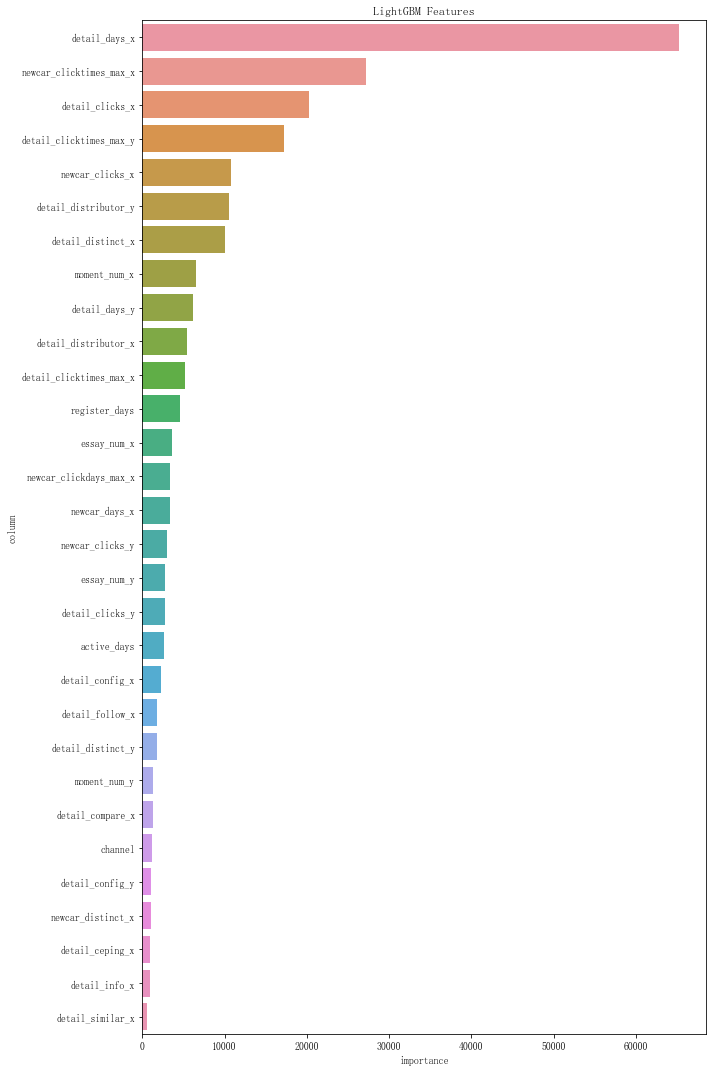

In [134]:
#特征重要性可视化
import matplotlib.pylab as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['FangSong'] #中文乱码

def lgb_importance():
    
    
    feature_names_pd = pd.DataFrame({'column': feature_names,
                                     'importance': lgb_1.feature_importance(importance_type = 'gain'),
                                     }).sort_values(by='importance')
    print(feature_names_pd)
    cols = feature_names_pd[["column", "importance"]].groupby("column").mean().sort_values(by="importance",ascending=False)[:30].index
                                         
    best_features = feature_names_pd.loc[feature_names_pd.column.isin(cols)]
    
    plt.figure(figsize=(10, 15))
    sns.barplot(x="importance", y="column", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()

lgb_importance()

In [147]:
extra=pd.read_excel(r'F:\work\11.13 线索评级\motor_secret_report1.xls',sheet_name='原始数据')
extra_negative_sample=extra.loc[extra['call_cost']<=90]
extra_negative_sample

,id,11,shop_id,shop_no,user_no,call_type,pool_key,city,sub_id,unconnected_cause,...,free_ring_time,partner_key,control_msg,secret_no,release_cause,control_type,release_time,call_cost,ring_cost,_class
0,1005869143040,254310136ksvm5083,254310.0,137oozo3285,136ksvm5083,0,FC100000110420903,北京,1000024182637040,0,...,2020-11-06 10:23:23,FC100000110420903,OK,185qgkp4304,31,CONTINUE,2020-11-06 10:23:28,0,3,com.motor.pretty.number.dto.SecretReportDTO
1,1005869767181,NaN,NaN,137oozo3285,188nshy2701,0,FC100000110420903,北京,1000024171485870,0,...,2020-11-06 10:39:14,FC100000110420903,OK,185sdkw4892,31,CONTINUE,2020-11-06 10:39:21,4,2,com.motor.pretty.number.dto.SecretReportDTO
2,1005870590848,NaN,NaN,137oozo3285,166yhtk9446,0,FC100000110420903,北京,1000024185540750,0,...,2020-11-06 10:59:32,FC100000110420903,OK,185rwvk6446,31,CONTINUE,2020-11-06 10:59:40,0,3,com.motor.pretty.number.dto.SecretReportDTO
3,1005896394856,NaN,NaN,137oozo3285,188nshy2701,0,FC100000110420903,北京,1000024235239400,0,...,2020-11-06 23:54:14,FC100000110420903,OK,185nipz4899,31,CONTINUE,2020-11-06 23:54:17,0,3,com.motor.pretty.number.dto.SecretReportDTO
4,1005896467951,254310136ksvm5083,254310.0,137oozo3285,136ksvm5083,0,FC100000110420903,北京,1000024235477340,0,...,2020-11-06 23:59:31,FC100000110420903,OK,185emnt5481,31,CONTINUE,2020-11-06 23:59:34,0,3,com.motor.pretty.number.dto.SecretReportDTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1005965899024,272504151dkcd4751,272504.0,133rurr8188,151dkcd4751,0,FC100000110420903,北京,1000024387873580,0,...,2020-11-09 11:13:44,FC100000110420903,OK,185euyp6042,16,CONTINUE,2020-11-09 11:14:01,7,5,com.motor.pretty.number.dto.SecretReportDTO
304,1005965719670,272504139gapp2852,272504.0,133rurr8188,139gapp2852,0,FC100000110420903,北京,1000024388122840,0,...,2020-11-09 11:14:36,FC100000110420903,OK,185cnfw7449,16,CONTINUE,2020-11-09 11:15:33,0,3,com.motor.pretty.number.dto.SecretReportDTO
305,1005966146134,272504185ldpn0956,272504.0,133rurr8188,185ldpn0956,0,FC100000110420903,北京,1000024388373000,0,...,2020-11-09 11:16:16,FC100000110420903,OK,185qaqy5864,19,CONTINUE,2020-11-09 11:17:06,0,5,com.motor.pretty.number.dto.SecretReportDTO
307,1005966243163,264044176ntyo6203,264044.0,155wsri8815,176ntyo6203,0,FC100000110420903,北京,1000024387209130,0,...,2020-11-09 11:20:14,FC100000110420903,OK,185sdkw4892,19,CONTINUE,2020-11-09 11:21:04,0,3,com.motor.pretty.number.dto.SecretReportDTO
